In [1]:
from transformers import ViTImageProcessor,ViTForImageClassification
from transformers import TrainingArguments,Trainer
import PIL
import matplotlib.pyplot as plt
import os
import tqdm
from datasets import load_dataset
import torch
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score,f1_score
import time
import seaborn as sns
import numpy as np
import cv2
from PIL import Image
import shutil

In [2]:
num_cores = os.cpu_count() 
print(num_cores)

4


In [3]:
train_dataset = load_dataset("imagefolder", data_dir="/kaggle/input/deepfake-and-real-images/Dataset/Train", num_proc=num_cores)
valid_dataset = load_dataset("imagefolder", data_dir="/kaggle/input/deepfake-and-real-images/Dataset/Validation", num_proc=num_cores)

Resolving data files:   0%|          | 0/140002 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Computing checksums:  58%|#####7    | 80999/140002 [00:05<00:03, 16186.56it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Resolving data files:   0%|          | 0/39428 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Generating train split: 0 examples [00:00, ? examples/s]

/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [4]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 140002
    })
})

In [5]:
valid_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 39428
    })
})

In [6]:
model_name='google/vit-base-patch16-224-in21k'
feature_extractor=ViTImageProcessor(model_name)
model=ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=2 
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
feature_extractor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": "google/vit-base-patch16-224-in21k",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [8]:
def process_example(example):
    inputs=feature_extractor(example['image'],return_tensors='pt')
    inputs['label']=example['label']
    return inputs

In [9]:
train_processed_ds=train_dataset.with_transform(process_example)

In [10]:
train_processed_ds['train'][0]['pixel_values'].shape

torch.Size([3, 224, 224])

In [11]:
valid_processed_ds=valid_dataset.with_transform(process_example)

In [12]:
valid_processed_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 39428
    })
})

In [13]:
training_args = TrainingArguments(
  output_dir="output",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=2,
  save_steps=1000,
  eval_steps=1000,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='none',
  load_best_model_at_end=True,
)



def compute_metrics(example):
    labels = example.label_ids
    preds = example.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)

    return {'accuracy': acc}



trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_processed_ds["train"],
    eval_dataset=valid_processed_ds["train"],
    tokenizer=feature_extractor,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
1000,0.268000,0.285747,0.903495
2000,0.072800,0.190807,0.937684
3000,0.095200,0.161765,0.940575
4000,0.167800,0.123351,0.953510
5000,0.137600,0.140179,0.951304
6000,0.087400,0.129013,0.954144
7000,0.142500,0.140807,0.947220
8000,0.079800,0.106682,0.962235
9000,0.079400,0.110486,0.970909
10000,0.068200,0.105165,0.969387


TrainOutput(global_step=17502, training_loss=0.08708740598443372, metrics={'train_runtime': 14197.4644, 'train_samples_per_second': 19.722, 'train_steps_per_second': 1.233, 'total_flos': 2.169806706004422e+19, 'train_loss': 0.08708740598443372, 'epoch': 2.0})

In [15]:
trainer.save_model("/kaggle/working/model")

In [16]:
shutil.make_archive('vit-model', 'zip', '/kaggle/working/model')

'/kaggle/working/vit-model.zip'

In [17]:
metrics = trainer.evaluate(valid_processed_ds['train'])
trainer.log_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.9782
  eval_loss               =     0.0741
  eval_runtime            = 0:06:30.60
  eval_samples_per_second =    100.941
  eval_steps_per_second   =     12.619


In [18]:
test_dataset = load_dataset("imagefolder", data_dir="/kaggle/input/deepfake-and-real-images/Dataset/Test", num_proc=num_cores)

Resolving data files:   0%|          | 0/10905 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Generating train split: 0 examples [00:00, ? examples/s]

/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [19]:
test_dataset_ds=test_dataset.with_transform(process_example)

In [20]:
test_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 10905
    })
})

In [21]:
metrics = trainer.evaluate(test_dataset_ds['train'])
trainer.log_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.9282
  eval_loss               =     0.2765
  eval_runtime            = 0:02:39.44
  eval_samples_per_second =     68.395
  eval_steps_per_second   =      8.555


In [22]:
predictions_output = trainer.predict(valid_processed_ds['train'])
logits = predictions_output.predictions
true_labels = predictions_output.label_ids

Confusion Matrix:
[[19203   438]
 [  421 19366]]
              precision    recall  f1-score   support

        Fake       0.98      0.98      0.98     19641
        Real       0.98      0.98      0.98     19787

    accuracy                           0.98     39428
   macro avg       0.98      0.98      0.98     39428
weighted avg       0.98      0.98      0.98     39428



<Axes: >

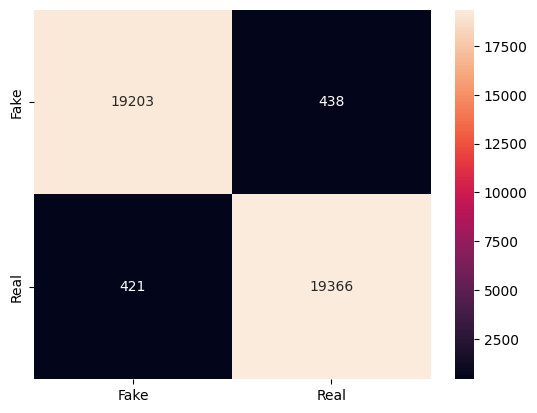

In [23]:
predicted_labels = np.argmax(logits, axis=1)
cm = confusion_matrix(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels, target_names=["Fake", "Real"]) 
print("Confusion Matrix:")
print(cm)
print(report)
classes=["Fake", "Real"]
sns.heatmap(cm,annot=True,fmt='g',xticklabels=classes,yticklabels=classes)

Confusion Matrix:
[[5354  138]
 [ 645 4768]]
              precision    recall  f1-score   support

        Fake       0.89      0.97      0.93      5492
        Real       0.97      0.88      0.92      5413

    accuracy                           0.93     10905
   macro avg       0.93      0.93      0.93     10905
weighted avg       0.93      0.93      0.93     10905



<Axes: >

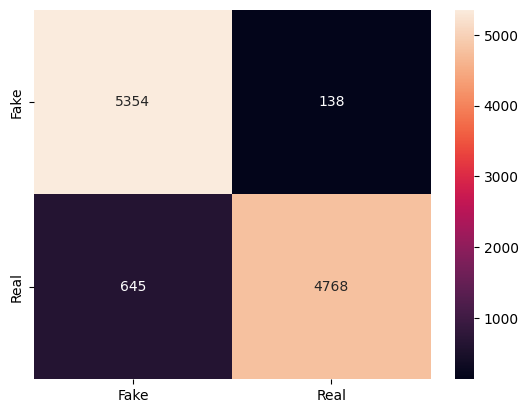

In [24]:
predictions_output = trainer.predict(test_dataset_ds['train'])
logits = predictions_output.predictions
true_labels = predictions_output.label_ids
predicted_labels = np.argmax(logits, axis=1)
cm = confusion_matrix(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels, target_names=["Fake", "Real"]) 
print("Confusion Matrix:")
print(cm)
print(report)
classes=["Fake", "Real"]
sns.heatmap(cm,annot=True,fmt='g',xticklabels=classes,yticklabels=classes)